# Import stuff

In [24]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import pdb
import os

# Initialize dataset, parameters and network arcitecthure

In [71]:
# Dataset
dataset = torchvision.datasets.MNIST(root='./data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

# Default optimization parameters
exp_params = {
    'epochs': 5,
    'batch_size': 15,
    'learning_rate': 0.001,
    'momentum': 0.9,
    'dataset_size': 0.1,                    # Reduce dataset size by this factor
    'train_size_ratio': 0.05                # This amount of remaining data should be set aside for training
}


# Default network architecture
img_size = 28
# Conv layer 1
filter_size1 = 5
num_filter1  =16
pool_size1 = 2

# Conv layer 2
filter_size2 = 5
num_filter2 =36
pool_size2 = 2

# Fully connected layer
lin_input_size = int( img_size**2 * num_filter2 / (pool_size1**2 * pool_size2**2) )
num_neuron =  128
num_classes = 10


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filter1, kernel_size=filter_size1,padding=filter_size1//2)
        self.conv2 = nn.Conv2d(num_filter1, num_filter2, kernel_size=filter_size2,padding=filter_size2//2)
        self.relu  = nn.ReLU()
        self.fc1 = nn.Linear(lin_input_size, num_neuron)
        self.fc2 = nn.Linear(num_neuron, num_classes)

    def forward(self, x):
        x=self.conv1(x)
        x= F.max_pool2d(x,pool_size1)
        w1=self.relu(x)
        x = self.conv2(w1)
        x=self.relu(x)
        w2=F.max_pool2d(x,pool_size2)
        x = w2.view(-1, lin_input_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return (x,w1,w2)

# Run experiment

In [77]:
import os
import datetime
import json

def new_experiment(exp_params):
    print("__NEW EXPERIMENT__")
    
    exp_path = os.path.join("exps", datetime.datetime.now().strftime("%Y_%M_%d-%T"))
    os.mkdir(exp_path)
    # Dump parameters for experiment for later reference
    with open(os.path.join(exp_path, "params.json"), 'w') as fp:
        json.dump(exp_params, fp, indent=4)
    
    # Define model and optimizer
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=exp_params['learning_rate'], momentum=exp_params['momentum'])
    criterion = nn.CrossEntropyLoss()
    
    
    # Split train and validation
    train_size = int(len(dataset)*exp_params['train_size_ratio'])
    val_size = len(dataset) - train_size
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=exp_params['batch_size'], 
                                           shuffle=True)    
    n_batches = len(train_loader)
    
    val_loader = torch.utils.data.DataLoader(dataset=val_set,
                                        batch_size=val_size, 
                                        shuffle=True)    
    val_images, val_labels = next(iter(val_loader))
    number_indexes = [np.where(val_labels == i)[0] for i in range(10)]
    
    # Allocate memory for val and training loss
    train_loss = np.zeros(exp_params['epochs'])
    val_loss = np.zeros((exp_params['epochs'], 10))
    
    
    # Start training loop
    for epoch in range(exp_params['epochs']):
        epoch_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs[0], labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, exp_params['epochs'], i+1, n_batches, loss.item()))
                
        train_loss[epoch] = epoch_loss / n_batches
        
        with torch.no_grad():
            for i in range(10):
                outputs = model(val_images[number_indexes[i]])
                val_loss[epoch, i] = criterion(outputs[0], val_labels[number_indexes[i]])
                
    return train_loss, val_loss

tl, vl = new_experiment(exp_params)

__NEW EXPERIMENT__
Epoch [1/5], Step [100/200], Loss: 2.2910
Epoch [1/5], Step [200/200], Loss: 2.2776
5647
6421
5670
5811
5558
5133
5604
5955
5563
5638
Epoch [2/5], Step [100/200], Loss: 2.2165
Epoch [2/5], Step [200/200], Loss: 1.9356
5647
6421
5670
5811
5558
5133
5604
5955
5563
5638
Epoch [3/5], Step [100/200], Loss: 1.1105
Epoch [3/5], Step [200/200], Loss: 0.6302
5647
6421
5670
5811
5558
5133
5604
5955
5563
5638
Epoch [4/5], Step [100/200], Loss: 0.5924
Epoch [4/5], Step [200/200], Loss: 0.6568
5647
6421
5670
5811
5558
5133
5604
5955
5563
5638
Epoch [5/5], Step [100/200], Loss: 0.5240
Epoch [5/5], Step [200/200], Loss: 1.3579
5647
6421
5670
5811
5558
5133
5604
5955
5563
5638


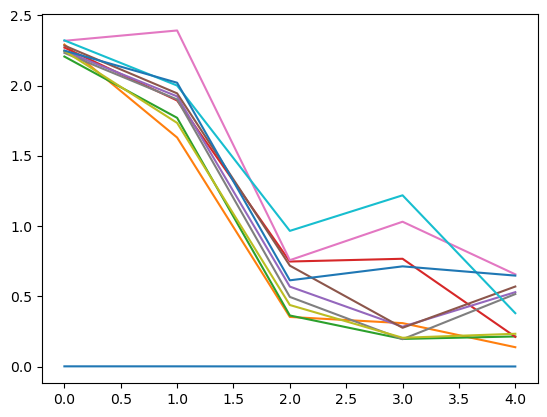

In [80]:
plt.plot(tl/2000)
plt.plot(vl)
plt.show()

In [27]:
# Split the test-set into smaller batches of this size.
test_batch_size = batch_size
model.eval() 
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    num_test = test_dataset.data.cpu().numpy().shape[0]
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    cls_true = np.zeros(shape=num_test, dtype=np.int)
    i = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs[0].data, 1)
            total += labels.size(0)
            #pdb.set_trace()
            correct += (predicted == labels).sum().item()
            # The ending index for the next batch is denoted j.
            j = min(i + test_batch_size, num_test)

            # Calculate the predicted class using TensorFlow.
            cls_pred[i:j] = predicted.detach().cpu().numpy()
            cls_true[i:j] =labels.detach().cpu().numpy()
            # Set the start-index for the next batch to the
            # end-index of the current batch.
            i = j

    # Convenience variable for the true class-numbers of the test-set.


    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred, cls_true=cls_true)

NameError: name 'batch_size' is not defined

In [32]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = test_dataset.data.cpu().numpy()[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = test_dataset.targets.cpu().numpy()[incorrect]
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [33]:
test_dataset.targets.cpu().numpy().shape

(10000,)

In [34]:
def plot_confusion_matrix(cls_pred,cls_true):
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    print(cm)

/tmp/ipykernel_49821/1522424286.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cls_pred = np.zeros(shape=num_test, dtype=np.int)
/tmp/ipykernel_49821/1522424286.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated

Accuracy on Test-Set: 98.6% (9857 / 10000)
Example errors:


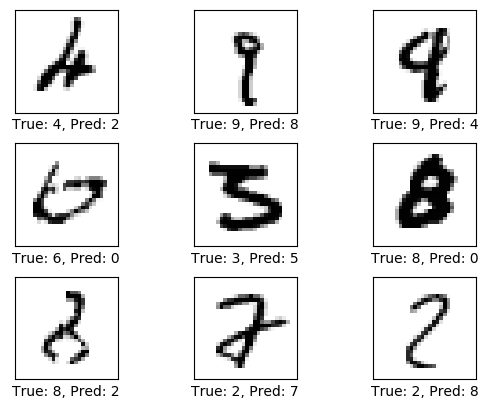

Confusion Matrix:
[[ 973    0    0    0    0    2    1    1    3    0]
 [   0 1118    1    0    0    0    2    2   12    0]
 [   2    0 1018    2    1    0    1    2    6    0]
 [   2    0    0  990    0   12    0    3    2    1]
 [   0    0    1    0  976    0    1    2    2    0]
 [   2    0    0    2    0  885    2    0    1    0]
 [   3    2    0    0    2    6  944    0    1    0]
 [   0    1    7    0    0    0    0 1015    5    0]
 [   3    0    2    3    0    2    1    1  960    2]
 [   0    3    0    0   10    4    0    4   10  978]]


In [35]:
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)

In [36]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')